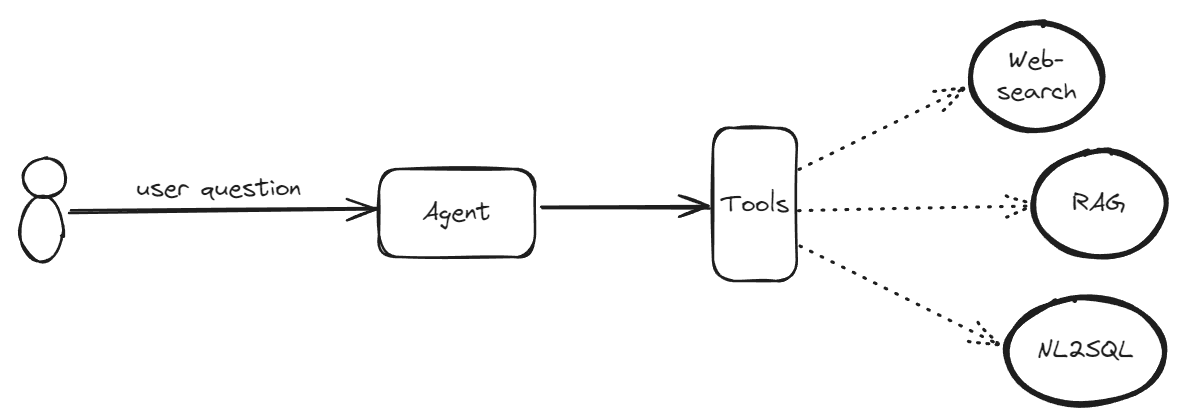

In [2]:
!pip install -r requirements.txt

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o')

In [5]:
from langchain_community.tools import DuckDuckGoSearchResults

In [6]:
search = DuckDuckGoSearchResults(num_results=2)
search.invoke("Give me temperature in NY")

/Users/mohamednajiaboo/Desktop/DocumentChat/Document_Chat_Langchain/env/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


"snippet: Today, gray skies in the morning will gradually clear, leading to a warmer, sunnier afternoon. The highest temperature will be an enjoyable 64.4°F, while the lowest forecasted temperature is a cool 51.8°F. The day's maximum of 64.4°F shows a shift toward May's pattern over April's. Sunrise will be at 6:16 am and sunset at 7:35 pm; the daylight will last for 13h and 19min., title: Weather today - New York, NY, link: https://www.weather-atlas.com/en/new-york-usa/new-york, snippet: New York City Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the New York City area., title: New York City, NY Weather Conditions | Weather Underground, link: https://www.wunderground.com/weather/us/ny/new-york-city"

In [7]:
!pip install duckduckgo-search

In [8]:
web_search_tool = DuckDuckGoSearchResults(num_results=2)

#RAG Tool 
- Load the document
- Split document
- save to vector db 

In [9]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from typing import List
from langchain_core.documents import Document

In [10]:
def load_document(folder_path: str) -> List[Document]:
    document = []
    for filename in os.listdir(folder_path):
        fil_path = os.path.join(folder_path, filename)
        if filename.endswith(".pdf"):
            loader = PyPDFLoader(file_path=fil_path)
        elif filename.endswith(".docx"):
            loader = Docx2txtLoader(file_path=fil_path)
        else:
            print(f"Unsupported file type")
        document.extend(loader.load())
    return document


In [11]:
folder_path = 'contents/docs'

In [12]:
documents = load_document(folder_path=folder_path)

In [13]:
print(f"Loaded {len(documents)}")

Loaded 8


In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [15]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size =1000,
    chunk_overlap = 200, 
    length_function = len
)

In [16]:
splits = text_splitter.split_documents(documents=documents)

In [17]:
print(len(splits))

17


In [18]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

In [19]:
collection_name = "my_collection"
vector_store = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=OpenAIEmbeddings(),
    persist_directory="./chroma_db"
)

In [20]:
from langchain.tools import tool
from pydantic import BaseModel

In [21]:
class RagToolSchema(BaseModel):
    question: str

In [22]:
@tool(args_schema=RagToolSchema)
def retriver_tool(question: str):
    """
        Tool to retrieve semantically similar documents to answer related to company leave policy
    """
    retriever = vector_store.as_retriever(search_kwargs={"k": 2})
    retriever_result = retriever.invoke(question)
    return "\n\n".join( doc.page_content for doc in retriever_result)


In [23]:
ret = vector_store.as_retriever(search_kwargs={"k": 2})
ret.invoke("Give me leave policy")

[Document(metadata={'page': 0, 'source': 'contents/docs/Leave-Policy-India.pdf'}, page_content='Leave Policy - INDIA'),
 Document(metadata={'page': 0, 'source': 'contents/docs/Leave-Policy-India.pdf'}, page_content='Leave Policy - INDIA')]

In [24]:
!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

--2025-04-16 15:54:26--  https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite [following]
--2025-04-16 15:54:27--  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067008 (1.0M) [application/octet-stream]
Saving to: ‘Chinook_Sqlite.sqlite’

Chinook_Sqlite.sqli 100%[===================>]   1.02M  1.98MB/

In [25]:

!mv Chinook_Sqlite.sqlite Chinook.db

In [26]:

import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


In [27]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [28]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [29]:
class SQlToolSchema(BaseModel):
    question : str

In [30]:
 from langchain.chains import create_sql_query_chain
 from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
 from operator import itemgetter
 import re
 from langchain_core.output_parsers import StrOutputParser
 from langchain_core.prompts import PromptTemplate
 from langchain_core.runnables import RunnablePassthrough, RunnableLambda

 class SQLToolSchema(BaseModel):
     question: str

 @tool(args_schema=SQLToolSchema)
 def nl2sql_tool(question):
   """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
   print("INSIDE NL2SQL TOOL")
   execute_query = QuerySQLDataBaseTool(db=db)
   write_query = create_sql_query_chain(llm, db)

   chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
   )

   response = chain.invoke({"question": question})
   return response['result']


In [31]:
question ="How many employees are there?"
result = nl2sql_tool.invoke({"question": question})

INSIDE NL2SQL TOOL


/var/folders/rj/djrt00t535d50y8w12q37gfc0000gn/T/ipykernel_41938/2970222711.py:16: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


In [32]:
result

'[(8,)]'

In [33]:
tools =[ web_search_tool, retriver_tool, nl2sql_tool]
llm_with_tools = llm.bind_tools(tools=tools)

In [34]:
from typing import TypedDict
from langgraph.prebuilt import ToolNode

In [35]:
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from typing import Annotated

In [36]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [45]:
def chatbot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [46]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[web_search_tool,retriver_tool,nl2sql_tool])
graph_builder.add_node("tools", tool_node)

In [47]:
from langgraph.prebuilt import tools_condition
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [48]:
graph = graph_builder.compile()

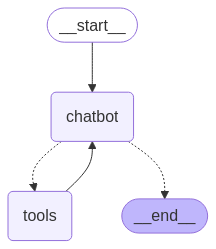

In [49]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
config = {"configurable": {"thread_id": "1"}}

In [53]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["q", "exit"]:
        print("Good Bye")

        break
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print(value)
            #print("Assistant:", value["messages"[-1]].content)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R2DIhch0QGnkmizlZzouPIDe', 'function': {'arguments': '{"question":"What is the total number of employees in the database?"}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 144, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a4c81500-24de-4180-90b6-8be960f6bbe8-0', tool_calls=[{'name': 'nl2sql_tool', 'args': {'question': 'What is the total number of employees in the database?'}, 'id': 'call_R2DIhch0QGnkmizlZzouPIDe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 144, 'output_tokens': 27, 'total_to

/Users/mohamednajiaboo/Desktop/DocumentChat/Document_Chat_Langchain/env/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'messages': [ToolMessage(content='snippet: California remains the 5th largest economy in the world since 2017. California is the 5th largest economy in the world for the seventh consecutive year, with a nominal GDP of nearly $3.9 trillion in 2023 and a growth rate of 6.1% since the year prior, according to the U.S. Bureau of Economic Analysis (BEA). On a per capita basis, California is ..., title: California Remains the World\'s 5th Largest Economy, link: https://www.gov.ca.gov/2024/04/16/california-remains-the-worlds-5th-largest-economy/, snippet: About $3.2 trillion in 2023. Gross domestic product (GDP) measures the value of goods and services a country or state produces — it\'s the sum of consumer spending, business investment, government spending, and net exports. It is often used to quantify the size of its economy. The $3.2 trillion is the "real GDP," which is adjusted to account for inflation to make it easier to compare ..., title: What is the gross domestic product (GDP) in C